<a href="https://colab.research.google.com/github/Ganeshkumbara/sam2_exploration/blob/main/Sam2_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 import torch
 import torchvision
 import cv2

In [ ]:
!nvidia-smi

Wed Aug 21 16:09:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
os.chdir('/home')

In [ ]:
!pwd

/home


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks')

Mounted at /content/drive


In [ ]:
home = os.getcwd()

In [ ]:
home

'/content/drive/My Drive/Colab Notebooks'

In [ ]:
!git clone https://github.com/facebookresearch/segment-anything-2.git


Cloning into 'segment-anything-2'...
remote: Enumerating objects: 510, done.
remote: Counting objects: 100% (206/206), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 510 (delta 152), reused 68 (delta 68), pack-reused 304 (from 1)
Receiving objects: 100% (510/510), 88.45 MiB | 16.41 MiB/s, done.
fatal: could not open '/content/drive/MyDrive/Colab Notebooks/segment-anything-2/segment-anything-2/.git/objects/pack/tmp_pack_RDdoqk' for reading: No such file or directory
fatal: fetch-pack: invalid index-pack output


In [ ]:
%cd {home}/segment-anything-2|
!pip install -e . -q

[Errno 2] No such file or directory: '/content/drive/My Drive/Colab Notebooks/segment-anything-2|'
/content/drive/My Drive/Colab Notebooks/segment-anything-2
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
The folder you are executing pip from can no longer be found.


In [ ]:
!pip install -q supervision jupyter_bbox_widget


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 28.1 MB/s eta 0:00:00


In [ ]:
!mkdir -p checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P checkpoints

Imports

In [ ]:
import cv2
import torch
import base64

import numpy as np
import supervision as sv

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

In [ ]:
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [ ]:
os.chdir(home)

In [ ]:
home

'/content/drive/My Drive/Colab Notebooks'

Load Model

In [ ]:

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = "checkpoints/sam2_hiera_tiny.pt"
CONFIG = "sam2_hiera_t.yaml"
sam2_model = build_sam2(CONFIG, CHECKPOINT, device=DEVICE, apply_postprocessing=False)

MissingConfigException: Primary config module 'sam2_configs' not found.
Check that it's correct and contains an __init__.py file

In [ ]:
mask_generator = SAM2AutomaticMaskGenerator(sam2_model)

In [ ]:
IMAGE_PATH = "emojis.png"

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam2_result = mask_generator.generate(image_rgb)

**Output format**

SAM2AutomaticMaskGenerator returns a list of masks, where each mask is a dict containing various information about the mask:

* segmentation - [np.ndarray] - the mask with (W, H) shape, and bool type


* area - [int] - the area of the mask in pixels

* bbox - [List[int]] - the boundary box of the mask in xywh format

* predicted_iou - [float] - the model's own prediction for the quality of the mask

* point_coords - [List[List[float]]] - the sampled input point that generated this mask

* stability_score - [float] - an additional measure of mask quality

* crop_box - List[int] - the crop of the image used to generate this mask in xywh format

In [ ]:
sam2_result[0]

{'segmentation': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'area': 1105902,
 'bbox': [0.0, 0.0, 1199.0, 1199.0],
 'predicted_iou': 0.99609375,
 'point_coords': [[18.75, 18.75]],
 'stability_score': 0.9693141579627991,
 'crop_box': [0.0, 0.0, 1200.0, 1200.0]}

Results visualisation

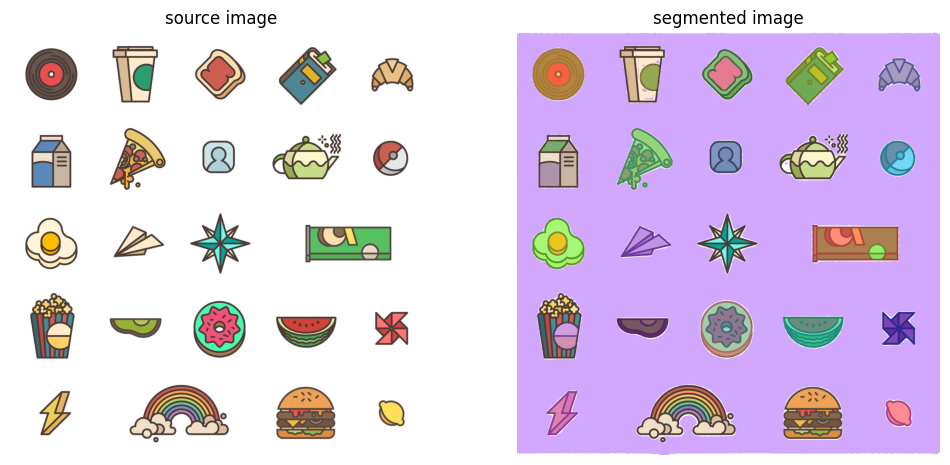

In [ ]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(sam_result=sam2_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)


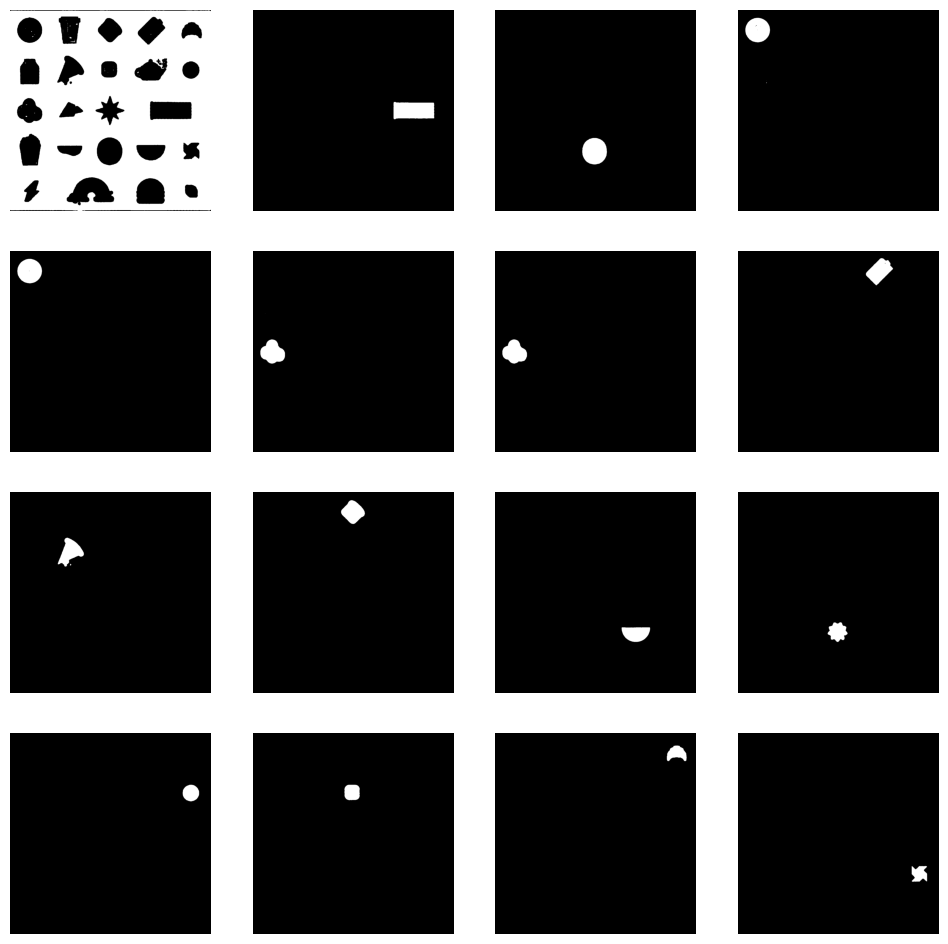

In [ ]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam2_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks[:16],
    grid_size=(4, 4),
    size=(12, 12)
)

**Advanced automatic mask generation options**

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes.

points_per_side [int or None] - the number of points to be sampled along one side of the image. The total number of points is points_per_side**2. If None, point_grids must provide explicit point sampling.

points_per_batch - [int] - sets the number of points run simultaneously by the model. Higher numbers may be faster but use more GPU memory.

pred_iou_thresh [float] - a filtering threshold in [0,1], using the model's predicted mask quality.

stability_score_thresh - [float] - a filtering threshold in [0,1], using the stability of the mask under changes to the cutoff used to binarize the model's mask predictions.

stability_score_offset - [float] - the amount to shift the cutoff when calculated the stability score.

mask_threshold - [float] - threshold for binarizing the mask logits

box_nms_thresh - [float] - the box IoU cutoff used by non-maximal suppression to filter duplicate masks.

crop_n_layers - [int] - if >0, mask prediction will be run again on crops of the image. Sets the number of layers to run, where each layer has 2**i_layer number of image crops.

crop_nms_thresh - [float] - the box IoU cutoff used by non-maximal suppression to filter duplicate masks between different crops.

crop_overlap_ratio - [float] - sets the degree to which crops overlap. In the first crop layer, crops will overlap by this fraction of the image length. Later layers with more crops scale down this overlap.

crop_n_points_downscale_factor - [int] - the number of points-per-side sampled in layer n is scaled down by crop_n_points_downscale_factor**n.

point_grids - [List[np.ndarray] or None] - a list over explicit grids of points

used for sampling, normalized to [0,1]. The nth grid in the list is used in the nth crop layer. Exclusive with points_per_side.

min_mask_region_area - [int] - if >0, postprocessing will be applied to remove disconnected regions and holes in masks with area smaller than min_mask_region_area. Requires opencv.

In [ ]:

mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2_model,
    points_per_side=64,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
)

In [ ]:

sam2_result_2 = mask_generator_2.generate(image_rgb)

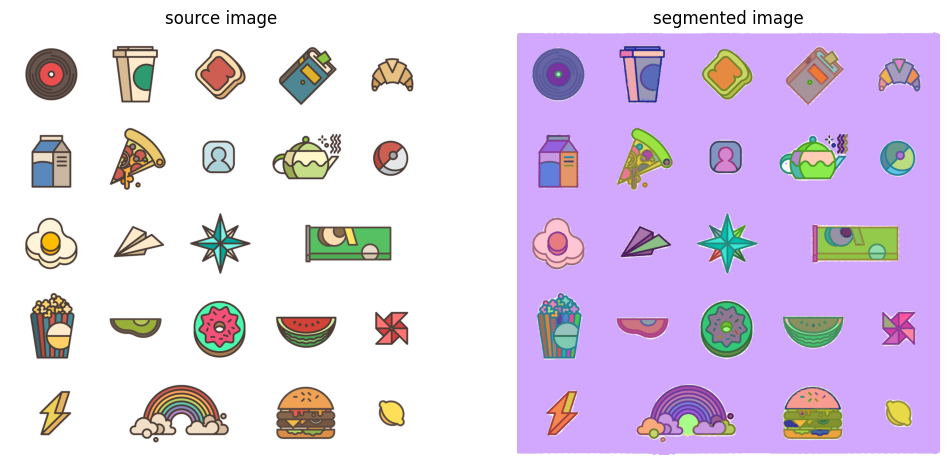

In [ ]:

mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(sam_result=sam2_result_2)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

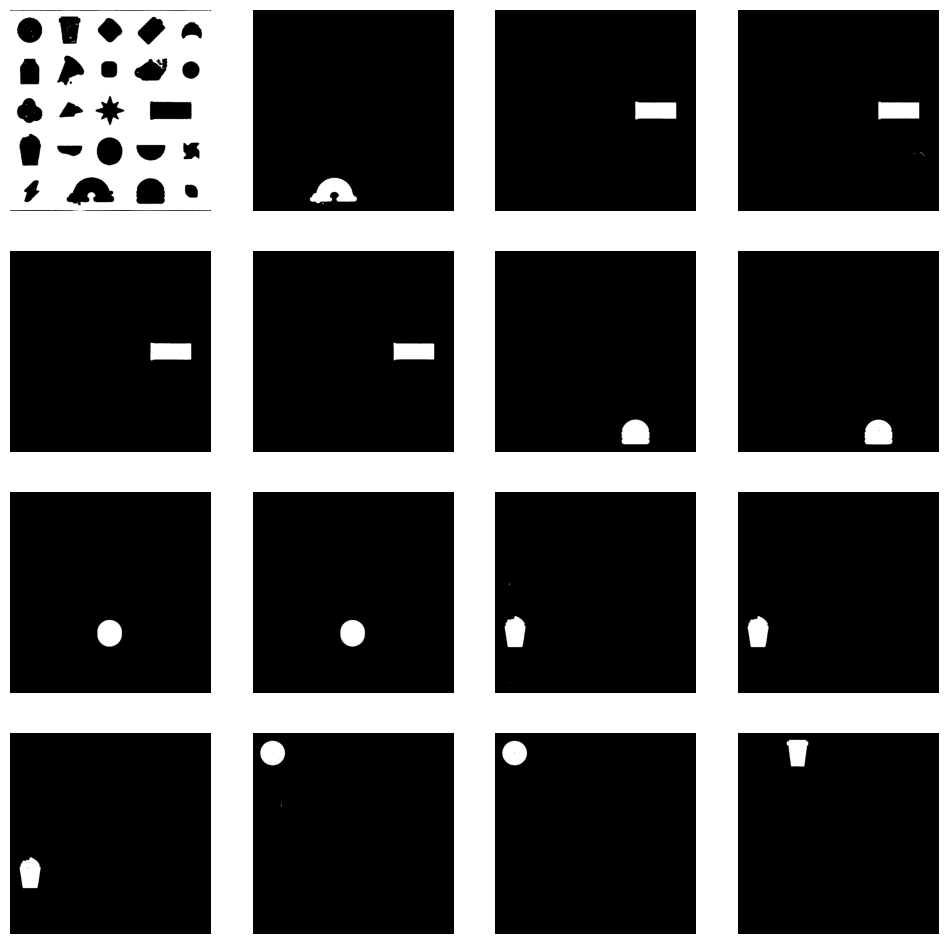

In [ ]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam2_result_2, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks[:16],
    grid_size=(4, 4),
    size=(12, 12)
)

**Prompting with boxes**

The SAM2ImagePredictor class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the set_image method, which calculates the necessary image embeddings. Then, prompts can be provided via the predict method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [ ]:
predictor = SAM2ImagePredictor(sam2_model)

In [ ]:

IMAGE_PATH = "34.jpg"

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

Interactive box prompt

In [ ]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

NOTE: Execute cell below and use your mouse to draw bounding box on the image 👇

In [ ]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [ ]:
widget.bboxes[0]["label"] = "table"
widget.bboxes[1]["label"] = "table"


In [ ]:
widget.bboxes

[{'x': 19, 'y': 344, 'width': 129, 'height': 165, 'label': 'table'},
 {'x': 347, 'y': 347, 'width': 126, 'height': 163, 'label': 'table'}]

NOTE: Sam2ImagePredictor.predict method takes np.ndarray box argument in [x_min, y_min, x_max, y_max] format.

In [ ]:
boxes = widget.bboxes
boxes = np.array([
    [
        box['x'],
        box['y'],
        box['x'] + box['width'],
        box['y'] + box['height']
    ] for box in boxes
])

In [ ]:
boxes

array([[ 19, 344, 148, 509],
       [347, 347, 473, 510]])

**Generate masks with SAM**

NOTE: Process the image to produce an image embedding by calling SAM2ImagePredictor.set_image. SAM2ImagePredictor remembers this embedding and will use it for subsequent mask prediction. SAM2ImagePredictor.predict takes the following arguments:

point_coords - [np.ndarray or None] - a Nx2 array of point prompts to the model. Each point is in (X,Y) in pixels.

point_labels - [np.ndarray or None] - a length N array of labels for the point prompts. 1 indicates a foreground point and 0 indicates a background point.

box - [np.ndarray or None] - a length 4 array given a box prompt to the model,
in [x_min, y_min, x_max, y_max] format.

mask_input - [np.ndarray] - a low resolution mask input to the model, typically coming from a previous prediction iteration. Has form 1xHxW, where for SAM, H=W=256.

multimask_output - [bool] - if true, the model will return three masks. For ambiguous input prompts (such as a single click), this will often produce better masks than a single prediction. If only a single mask is needed, the model's predicted quality score can be used to select the best mask. For non-ambiguous prompts, such as multiple input prompts, multimask_output=False can give better results.

return_logits - [bool] - if true, returns un-thresholded masks logits instead of a binary mask.

normalize_coords - [bool] - if true, the point coordinates will be normalized to the range [0,1] and point_coords is expected to be wrt. image dimensions.

In [ ]:

predictor.set_image(image_rgb)

masks, scores, logits = predictor.predict(
    box=boxes,
    multimask_output=False
)
print(len(masks))
masks = np.squeeze(masks)

2


In [ ]:
logits

array([[[[-14.6875 , -15.625  , -14.9375 , ..., -15.625  , -15.     ,
          -15.4375 ],
         [-15.75   , -15.5    , -15.125  , ..., -15.5625 , -15.25   ,
          -15.0625 ],
         [-15.4375 , -16.375  , -15.875  , ..., -16.875  , -17.375  ,
          -16.625  ],
         ...,
         [ -8.25   ,  -6.25   ,  -6.84375, ..., -13.4375 , -13.3125 ,
          -13.25   ],
         [ -7.0625 ,  -7.1875 ,  -7.4375 , ..., -14.1875 , -14.125  ,
          -13.75   ],
         [ -6.875  ,  -6.46875,  -6.9375 , ..., -13.125  , -13.875  ,
          -13.4375 ]]],


       [[[-16.     , -17.5    , -16.5    , ..., -16.5    , -15.75   ,
          -16.375  ],
         [-18.     , -16.75   , -17.375  , ..., -15.75   , -16.375  ,
          -15.6875 ],
         [-16.625  , -17.125  , -17.875  , ..., -17.125  , -18.     ,
          -17.375  ],
         ...,
         [-17.875  , -16.25   , -16.75   , ..., -12.4375 , -12.625  ,
          -11.6875 ],
         [-15.8125 , -16.25   , -17.     , ..., 

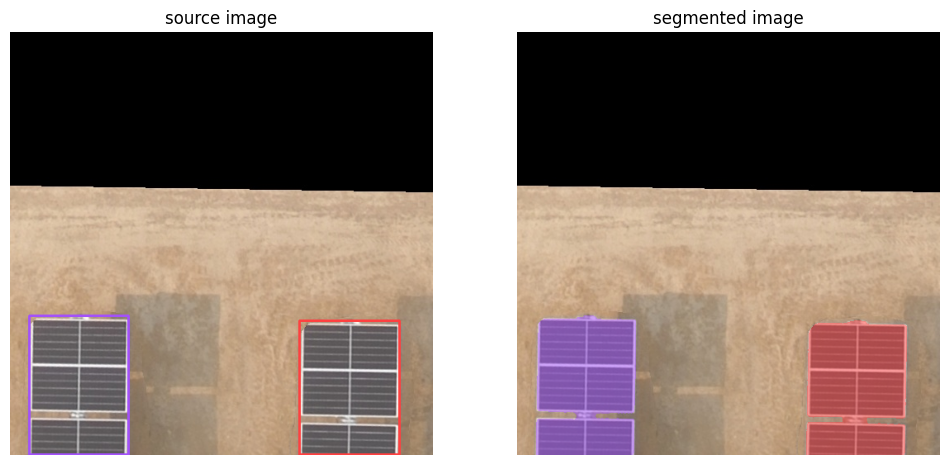

In [ ]:

box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks.astype(bool)
)

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

**Results visualisation**